In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scanpy as sc
import numpy as np
from scipy.stats import median_abs_deviation
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from scipy.sparse import issparse
from pathlib import Path
import os 
from scipy import sparse

In [2]:
import cellxgene_census
census = cellxgene_census.open_soma(census_version="2025-01-30")

## Look for viable datasets

In [3]:
cells = cellxgene_census.get_obs(
    census=census,
    organism="Homo sapiens",
    value_filter=(
        "tissue == 'blood' and "
        "disease == 'normal' and "
        "suspension_type == 'cell' and "
        "development_stage not in ["
        "'pediatric stage', 'child stage (1-4 yo)', 'juvenile stage (5-14 yo)', "
        "'postnatal stage', 'newborn stage (0-28 days)', '3-year-old stage', "
        "'11-year-old stage', '1-year-old stage', '2-year-old stage'] and "
        "is_primary_data == True and "
        "assay in ["
        "'10x 3\\' v3', '10x 3\\' v2', '10x 3\\' v1', '10x 3\\' transcription profiling'] and "
        "dataset_id not in ["
        "'5bc42b88-bb76-4954-927b-8bb7369adc64', " # manually exclude Vento-Tormo dataset (pregnant uterus)
        "'74cff64f-9da9-4b2a-9b3b-8a04a1598040', " # manually exclude Arutyunyan dataset (early pregnancy)
        "'9c1b5626-58df-4401-ae7b-f66d068c1551', " # manually exclude De Simone dataset (replicate 1/2)
        "'c54c9659-1b6b-4d4a-96f0-7dc987410f2d',"  # manually exclude De Simone dataset (replicate 2/2)
        "'ed5d841d-6346-47d4-ab2f-7119ad7e3a35']"  # manually exclude Hao, since we will use our own annotated version of it
    )
)
cells

,soma_joinid,dataset_id,assay,assay_ontology_term_id,cell_type,cell_type_ontology_term_id,development_stage,development_stage_ontology_term_id,disease,disease_ontology_term_id,...,tissue,tissue_ontology_term_id,tissue_type,tissue_general,tissue_general_ontology_term_id,raw_sum,nnz,raw_mean_nnz,raw_variance_nnz,n_measured_vars
0,4290407,d18736c3-6292-4379-919a-d6d973204c87,10x 3' v3,EFO:0009922,myeloid dendritic cell,CL:0000782,young adult stage,HsapDv:0000266,normal,PATO:0000461,...,blood,UBERON:0000178,tissue,blood,UBERON:0000178,136.0,107,1.271028,0.765473,21946
1,4290408,d18736c3-6292-4379-919a-d6d973204c87,10x 3' v3,EFO:0009922,"central memory CD4-positive, alpha-beta T cell",CL:0000904,young adult stage,HsapDv:0000266,normal,PATO:0000461,...,blood,UBERON:0000178,tissue,blood,UBERON:0000178,126.0,105,1.200000,0.373077,21946
2,4290412,d18736c3-6292-4379-919a-d6d973204c87,10x 3' v3,EFO:0009922,myeloid dendritic cell,CL:0000782,young adult stage,HsapDv:0000266,normal,PATO:0000461,...,blood,UBERON:0000178,tissue,blood,UBERON:0000178,143.0,130,1.100000,0.121705,21946
3,4290415,d18736c3-6292-4379-919a-d6d973204c87,10x 3' v3,EFO:0009922,myeloid dendritic cell,CL:0000782,middle aged stage,HsapDv:0000267,normal,PATO:0000461,...,blood,UBERON:0000178,tissue,blood,UBERON:0000178,347.0,238,1.457983,1.000337,21946
4,4290416,d18736c3-6292-4379-919a-d6d973204c87,10x 3' v3,EFO:0009922,classical monocyte,CL:0000860,young adult stage,HsapDv:0000266,normal,PATO:0000461,...,blood,UBERON:0000178,tissue,blood,UBERON:0000178,150.0,123,1.219512,0.861255,21946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2721610,103537177,53d208b0-2cfd-4366-9866-c3c6114081bc,10x 3' v3,EFO:0009922,classical monocyte,CL:0000860,33-year-old stage,HsapDv:0000127,normal,PATO:0000461,...,blood,UBERON:0000178,tissue,blood,UBERON:0000178,17178.0,4603,3.731914,95.124116,61759
2721611,103537178,53d208b0-2cfd-4366-9866-c3c6114081bc,10x 3' v3,EFO:0009922,B cell,CL:0000236,33-year-old stage,HsapDv:0000127,normal,PATO:0000461,...,blood,UBERON:0000178,tissue,blood,UBERON:0000178,10264.0,3156,3.252218,44.415605,61759
2721612,103537179,53d208b0-2cfd-4366-9866-c3c6114081bc,10x 3' v3,EFO:0009922,plasma cell,CL:0000786,33-year-old stage,HsapDv:0000127,normal,PATO:0000461,...,blood,UBERON:0000178,tissue,blood,UBERON:0000178,6651.0,2277,2.920949,204.478810,61759
2721613,103537180,53d208b0-2cfd-4366-9866-c3c6114081bc,10x 3' v3,EFO:0009922,"CD8-positive, alpha-beta T cell",CL:0000625,33-year-old stage,HsapDv:0000127,normal,PATO:0000461,...,blood,UBERON:0000178,tissue,blood,UBERON:0000178,8861.0,3408,2.600059,31.242113,61759


In [4]:
# Get the cell counts per dataset
census_datasets = (
    census["census_info"]["datasets"]
    .read(column_names=["collection_name", "collection_doi_label", "dataset_title", "citation", "dataset_id", "soma_joinid"])
    .concat()
    .to_pandas()
)

dataset_cell_counts = pd.DataFrame(cells["dataset_id"].value_counts())
dataset_cell_counts = dataset_cell_counts.rename(columns={0: "cell_counts"})
dataset_cell_counts = dataset_cell_counts.merge(census_datasets, on="dataset_id")

# skip datasets with many or few cells
dataset_cell_counts_healthy_blood = dataset_cell_counts[(dataset_cell_counts['count'] > 5000) & (dataset_cell_counts['count'] < 200000)].copy()

In [5]:
# fix dataset_id for the following datasets
def process_dataset_id(row):
    value = row['collection_doi_label']
    index = row['dataset_id']  # If 'index' is in a column instead, use row['index']

    if value == "Cambridge Institute of Therapeutic Immunology and Infectious Disease-National Institute of Health Research (CITIID-NIHR) COVID-19 BioResource Collaboration et al. (2021) Nat Med":
        return "BioResourceCollaboration"

    elif value == "Jin et al. (2021) iScience":
        if index == "5e717147-0f75-4de1-8bd2-6fda01b8d75f":
            return "SchulteSchrepping"
        elif index == "59b69042-47c2-47fd-ad03-d21beb99818f":
            return "Arunachalam"

    if value == "The Tabula Sapiens Consortium* et al. (2022) Science":
        return "TabulaSapiens"
    
    if value == "Domínguez Conde et al. (2022) Science":
        return "DominguezConde"                

    # Default case: return everything before the first ' ('
    return value.split(" et")[0]

dataset_cell_counts_healthy_blood['dataset_id_custom'] = dataset_cell_counts_healthy_blood.apply(process_dataset_id, axis=1)

In [10]:
# list of final datasets from census
dataset_cell_counts_healthy_blood

,dataset_id,count,collection_name,collection_doi_label,dataset_title,citation,soma_joinid,dataset_id_custom
4,c7775e88-49bf-4ba2-a03b-93f00447c958,104923,Single-cell multi-omics analysis of the immune...,Cambridge Institute of Therapeutic Immunology ...,Single-cell multi-omics analysis of the immune...,Publication: https://doi.org/10.1038/s41591-02...,1517,BioResourceCollaboration
5,53d208b0-2cfd-4366-9866-c3c6114081bc,75461,Tabula Sapiens,The Tabula Sapiens Consortium* et al. (2022) S...,Tabula Sapiens - All Cells,Publication: https://doi.org/10.1126/science.a...,1569,TabulaSapiens
6,d18736c3-6292-4379-919a-d6d973204c87,60080,Single-cell RNA-seq analysis reveals cell subs...,Binvignat et al. (2024) JCI Insight,Single-cell RNA-seq analysis reveals cell subs...,Publication: https://doi.org/10.1172/jci.insig...,842,Binvignat
7,5e717147-0f75-4de1-8bd2-6fda01b8d75f,45787,A Web Portal and Workbench for Biological Diss...,Jin et al. (2021) iScience,Individual Single-Cell RNA-seq PBMC Data from ...,Publication: https://doi.org/10.1016/j.isci.20...,1169,SchulteSchrepping
8,59b69042-47c2-47fd-ad03-d21beb99818f,25954,A Web Portal and Workbench for Biological Diss...,Jin et al. (2021) iScience,Individual Single-Cell RNA-seq PBMC Data from ...,Publication: https://doi.org/10.1016/j.isci.20...,1082,Arunachalam
9,1b9d8702-5af8-4142-85ed-020eb06ec4f6,21965,Cross-tissue immune cell analysis reveals tiss...,Domínguez Conde et al. (2022) Science,Global,Publication: https://doi.org/10.1126/science.a...,1448,DominguezConde
10,19e46756-9100-4e01-8b0e-23b557558a4c,19631,Multiomic Profiling of Human Clonal Hematopoie...,Heimlich et al. (2024) Blood Advances,Single Cell Sequencing of Human PBMCs in Clona...,Publication: https://doi.org/10.1182/bloodadva...,948,Heimlich
11,de2c780c-1747-40bd-9ccf-9588ec186cee,17590,Immunophenotyping of COVID-19 and influenza hi...,Lee et al. (2020) Sci. Immunol.,Immunophenotyping of COVID-19 and influenza hi...,Publication: https://doi.org/10.1126/sciimmuno...,871,Lee


/tmp/ipykernel_1258837/922700400.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='dataset_id_custom', y='count', data=dataset_cell_counts_healthy_blood, palette="viridis")


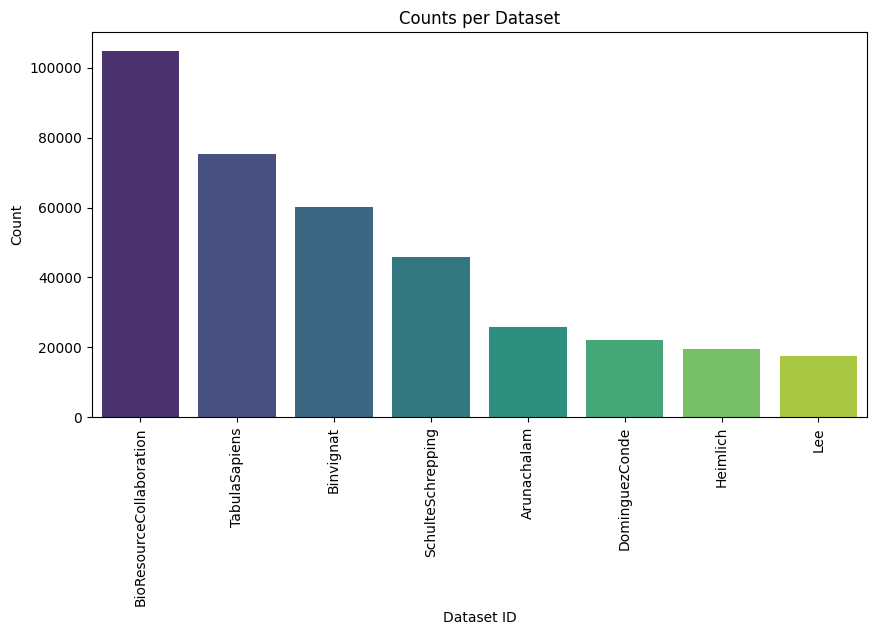

In [16]:
# Create bar plot
plt.figure(figsize=(10, 5))
sns.barplot(x='dataset_id_custom', y='count', data=dataset_cell_counts_healthy_blood, palette="viridis")

# Labeling
plt.xlabel('Dataset ID')
plt.ylabel('Count')
plt.title('Counts per Dataset')
plt.xticks(rotation=90) 

plt.show()

In [11]:
# collect metadata for all cells to be downloaded
cells_filtered = cells[cells['dataset_id'].isin(dataset_cell_counts_healthy_blood['dataset_id'])].copy()
cells_filtered = cells_filtered.merge(dataset_cell_counts_healthy_blood, on="dataset_id", suffixes=('_cells', '_datasets'))
cells_filtered['dataset_id'] = cells_filtered['dataset_id'].cat.remove_unused_categories()
cells_filtered['cell_type'] = cells_filtered['cell_type'].cat.remove_unused_categories()
cells_filtered['assay'] = cells_filtered['assay'].cat.remove_unused_categories()
cells_filtered

,soma_joinid_cells,dataset_id,assay,assay_ontology_term_id,cell_type,cell_type_ontology_term_id,development_stage,development_stage_ontology_term_id,disease,disease_ontology_term_id,...,raw_mean_nnz,raw_variance_nnz,n_measured_vars,count,collection_name,collection_doi_label,dataset_title,citation,soma_joinid_datasets,dataset_id_custom
0,4290407,d18736c3-6292-4379-919a-d6d973204c87,10x 3' v3,EFO:0009922,myeloid dendritic cell,CL:0000782,young adult stage,HsapDv:0000266,normal,PATO:0000461,...,1.271028,0.765473,21946,60080,Single-cell RNA-seq analysis reveals cell subs...,Binvignat et al. (2024) JCI Insight,Single-cell RNA-seq analysis reveals cell subs...,Publication: https://doi.org/10.1172/jci.insig...,842,Binvignat
1,4290408,d18736c3-6292-4379-919a-d6d973204c87,10x 3' v3,EFO:0009922,"central memory CD4-positive, alpha-beta T cell",CL:0000904,young adult stage,HsapDv:0000266,normal,PATO:0000461,...,1.200000,0.373077,21946,60080,Single-cell RNA-seq analysis reveals cell subs...,Binvignat et al. (2024) JCI Insight,Single-cell RNA-seq analysis reveals cell subs...,Publication: https://doi.org/10.1172/jci.insig...,842,Binvignat
2,4290412,d18736c3-6292-4379-919a-d6d973204c87,10x 3' v3,EFO:0009922,myeloid dendritic cell,CL:0000782,young adult stage,HsapDv:0000266,normal,PATO:0000461,...,1.100000,0.121705,21946,60080,Single-cell RNA-seq analysis reveals cell subs...,Binvignat et al. (2024) JCI Insight,Single-cell RNA-seq analysis reveals cell subs...,Publication: https://doi.org/10.1172/jci.insig...,842,Binvignat
3,4290415,d18736c3-6292-4379-919a-d6d973204c87,10x 3' v3,EFO:0009922,myeloid dendritic cell,CL:0000782,middle aged stage,HsapDv:0000267,normal,PATO:0000461,...,1.457983,1.000337,21946,60080,Single-cell RNA-seq analysis reveals cell subs...,Binvignat et al. (2024) JCI Insight,Single-cell RNA-seq analysis reveals cell subs...,Publication: https://doi.org/10.1172/jci.insig...,842,Binvignat
4,4290416,d18736c3-6292-4379-919a-d6d973204c87,10x 3' v3,EFO:0009922,classical monocyte,CL:0000860,young adult stage,HsapDv:0000266,normal,PATO:0000461,...,1.219512,0.861255,21946,60080,Single-cell RNA-seq analysis reveals cell subs...,Binvignat et al. (2024) JCI Insight,Single-cell RNA-seq analysis reveals cell subs...,Publication: https://doi.org/10.1172/jci.insig...,842,Binvignat
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371386,103537177,53d208b0-2cfd-4366-9866-c3c6114081bc,10x 3' v3,EFO:0009922,classical monocyte,CL:0000860,33-year-old stage,HsapDv:0000127,normal,PATO:0000461,...,3.731914,95.124116,61759,75461,Tabula Sapiens,The Tabula Sapiens Consortium* et al. (2022) S...,Tabula Sapiens - All Cells,Publication: https://doi.org/10.1126/science.a...,1569,TabulaSapiens
371387,103537178,53d208b0-2cfd-4366-9866-c3c6114081bc,10x 3' v3,EFO:0009922,B cell,CL:0000236,33-year-old stage,HsapDv:0000127,normal,PATO:0000461,...,3.252218,44.415605,61759,75461,Tabula Sapiens,The Tabula Sapiens Consortium* et al. (2022) S...,Tabula Sapiens - All Cells,Publication: https://doi.org/10.1126/science.a...,1569,TabulaSapiens
371388,103537179,53d208b0-2cfd-4366-9866-c3c6114081bc,10x 3' v3,EFO:0009922,plasma cell,CL:0000786,33-year-old stage,HsapDv:0000127,normal,PATO:0000461,...,2.920949,204.478810,61759,75461,Tabula Sapiens,The Tabula Sapiens Consortium* et al. (2022) S...,Tabula Sapiens - All Cells,Publication: https://doi.org/10.1126/science.a...,1569,TabulaSapiens
371389,103537180,53d208b0-2cfd-4366-9866-c3c6114081bc,10x 3' v3,EFO:0009922,"CD8-positive, alpha-beta T cell",CL:0000625,33-year-old stage,HsapDv:0000127,normal,PATO:0000461,...,2.600059,31.242113,61759,75461,Tabula Sapiens,The Tabula Sapiens Consortium* et al. (2022) S...,Tabula Sapiens - All Cells,Publication: https://doi.org/10.1126/science.a...,1569,TabulaSapiens


In [12]:
# count the number of cells per cell-type and dataset

cell_counts = cells_filtered.groupby(['dataset_id_custom', 'cell_type', 'assay']).size().reset_index(name='count_celltype')
cell_counts = cell_counts[cell_counts['count_celltype'] > 0]
cell_counts_dataset = cell_counts.merge(dataset_cell_counts_healthy_blood, on="dataset_id_custom")
cell_counts_dataset['proportion_celltype'] = (cell_counts_dataset['count_celltype'] / cell_counts_dataset['count']) * 100
cell_counts_dataset["assay_short"] = cell_counts_dataset["assay"].str.extract(r"([^']*')")

cell_counts_dataset

/tmp/ipykernel_4158912/2675821262.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cell_counts = cells_filtered.groupby(['dataset_id_custom', 'cell_type', 'assay']).size().reset_index(name='count_celltype')


,dataset_id_custom,cell_type,assay,count_celltype,dataset_id,count,collection_name,collection_doi_label,dataset_title,citation,soma_joinid,proportion_celltype,assay_short
0,Arunachalam,"CD16-negative, CD56-bright natural killer cell...",10x 3' v3,128,59b69042-47c2-47fd-ad03-d21beb99818f,25954,A Web Portal and Workbench for Biological Diss...,Jin et al. (2021) iScience,Individual Single-Cell RNA-seq PBMC Data from ...,Publication: https://doi.org/10.1016/j.isci.20...,1082,0.493180,10x 3'
1,Arunachalam,"CD4-positive, alpha-beta cytotoxic T cell",10x 3' v3,596,59b69042-47c2-47fd-ad03-d21beb99818f,25954,A Web Portal and Workbench for Biological Diss...,Jin et al. (2021) iScience,Individual Single-Cell RNA-seq PBMC Data from ...,Publication: https://doi.org/10.1016/j.isci.20...,1082,2.296371,10x 3'
2,Arunachalam,"activated CD4-positive, alpha-beta T cell, human",10x 3' v3,12,59b69042-47c2-47fd-ad03-d21beb99818f,25954,A Web Portal and Workbench for Biological Diss...,Jin et al. (2021) iScience,Individual Single-Cell RNA-seq PBMC Data from ...,Publication: https://doi.org/10.1016/j.isci.20...,1082,0.046236,10x 3'
3,Arunachalam,"activated CD8-positive, alpha-beta T cell, human",10x 3' v3,1,59b69042-47c2-47fd-ad03-d21beb99818f,25954,A Web Portal and Workbench for Biological Diss...,Jin et al. (2021) iScience,Individual Single-Cell RNA-seq PBMC Data from ...,Publication: https://doi.org/10.1016/j.isci.20...,1082,0.003853,10x 3'
4,Arunachalam,"central memory CD4-positive, alpha-beta T cell",10x 3' v3,2812,59b69042-47c2-47fd-ad03-d21beb99818f,25954,A Web Portal and Workbench for Biological Diss...,Jin et al. (2021) iScience,Individual Single-Cell RNA-seq PBMC Data from ...,Publication: https://doi.org/10.1016/j.isci.20...,1082,10.834553,10x 3'
...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,TabulaSapiens,non-classical monocyte,10x 3' v3,340,53d208b0-2cfd-4366-9866-c3c6114081bc,75461,Tabula Sapiens,The Tabula Sapiens Consortium* et al. (2022) S...,Tabula Sapiens - All Cells,Publication: https://doi.org/10.1126/science.a...,1569,0.450564,10x 3'
193,TabulaSapiens,plasma cell,10x 3' v3,664,53d208b0-2cfd-4366-9866-c3c6114081bc,75461,Tabula Sapiens,The Tabula Sapiens Consortium* et al. (2022) S...,Tabula Sapiens - All Cells,Publication: https://doi.org/10.1126/science.a...,1569,0.879925,10x 3'
194,TabulaSapiens,plasmacytoid dendritic cell,10x 3' v3,29,53d208b0-2cfd-4366-9866-c3c6114081bc,75461,Tabula Sapiens,The Tabula Sapiens Consortium* et al. (2022) S...,Tabula Sapiens - All Cells,Publication: https://doi.org/10.1126/science.a...,1569,0.038430,10x 3'
195,TabulaSapiens,platelet,10x 3' v3,371,53d208b0-2cfd-4366-9866-c3c6114081bc,75461,Tabula Sapiens,The Tabula Sapiens Consortium* et al. (2022) S...,Tabula Sapiens - All Cells,Publication: https://doi.org/10.1126/science.a...,1569,0.491645,10x 3'


Relabel cell types:

In [14]:
cell_type_mapping = {
    # T cells
    "alpha-beta T cell": "T cell",
    "activated type II NK T cell": "T cell",
    "CD4-negative, CD8-negative, alpha-beta intraepithelial T cell": "T cell",
    "double negative thymocyte": "T cell",
    "double negative thymocytes": "T cell",
    "double-positive, alpha-beta thymocyte": "T cell",
    "double-positive, alpha-beta thymocytes": "T cell",
    "gamma-delta T cell": "T cell",
    "lymphocyte": "T cell",
    "mature alpha-beta T cell": "T cell",
    "mature gamma-delta T cell": "T cell",
    "memory T cell": "T cell",
    "mucosal invariant T cell": "T cell",
    "T cell": "T cell",

    # CD4 T cells
    "CD4-positive, alpha-beta T cell": "T cells CD4 conv",
    "CD4-positive, alpha-beta cytotoxic T cell": "T cells CD4 conv",
    "CD4-positive, alpha-beta memory T cell": "T cells CD4 conv",
    "CD4-positive helper T cell": "T cells CD4 conv",
    "activated CD4-positive, alpha-beta T cell": "T cells CD4 conv",
    "activated CD4-positive, alpha-beta T cell, human": "T cells CD4 conv",
    "central memory CD4-positive, alpha-beta T cell": "T cells CD4 conv",
    "effector CD4-positive, alpha-beta T cell": "T cells CD4 conv",
    "effector memory CD4-positive, alpha-beta T cell": "T cells CD4 conv",
    "naive thymus-derived CD4-positive, alpha-beta T cell": "T cells CD4 conv",
    "T follicular helper cell": "T cells CD4 conv",
    "T-helper 1 cell": "T cells CD4 conv",
    "T-helper 2 cell": "T cells CD4 conv",
    "T-helper 17 cell": "T cells CD4 conv",
    "T-helper 22 cell": "T cells CD4 conv",

    # CD8 T cells
    "CD8-positive, alpha-beta T cell": "T cells CD8",
    "CD8-positive, alpha-beta cytotoxic T cell": "T cells CD8",
    "CD8-positive, alpha-beta memory T cell": "T cells CD8",
    "CD8-positive, alpha-beta memory T cell, CD45RO-positive": "T cells CD8",
    "activated CD8-positive, alpha-beta T cell": "T cells CD8",
    "activated CD8-positive, alpha-beta T cell, human": "T cells CD8",
    "central memory CD8-positive, alpha-beta T cell": "T cells CD8",
    "cytotoxic T cell": "T cells CD8",
    "effector CD8-positive, alpha-beta T cell": "T cells CD8",
    "effector memory CD8-positive, alpha-beta T cell": "T cells CD8",
    "effector memory CD8-positive, alpha-beta T cell, terminally differentiated": "T cells CD8",
    "naive thymus-derived CD8-positive, alpha-beta T cell": "T cells CD8",
    
    # Tregs
    "regulatory T cell": "Tregs",
    "memory regulatory T cell": "Tregs",
    "naive regulatory T cell": "Tregs",
    "double negative T regulatory cell": "Tregs",
    "CD4-positive, CD25-positive, alpha-beta regulatory T cell": "Tregs",
    
    # B cells
    "B cell": "B cells",
    "mature B cell": "B cells",
    "memory B cell": "B cells",
    "naive B cell": "B cells",
    "plasma cell": "Plasma cells",
    "plasmablast": "Plasma cells",
    "class switched memory B cell": "B cells",
    "IgA plasma cell": "Plasma cells",
    "IgG plasma cell": "Plasma cells",
    "IgG-negative class switched memory B cell": "B cells",
    "IgM plasma cell": "Plasma cells",
    "unswitched memory B cell": "B cells",
    "immature B cell": "B cells",
    "IgG memory B cell": "B cells",
    "transitional stage B cell": "B cells",
    
    # Monocytes
    "classical monocyte": "Monocytes",
    "non-classical monocyte": "Monocytes",
    "CD14-positive, CD16-negative classical monocyte": "Monocytes",
    "CD14-low, CD16-positive monocyte": "Monocytes",
    "CD14-positive monocyte": "Monocytes",
    "intermediate monocyte": "Monocytes",
    "MHC-II-positive classical monocyte": "Monocytes",
    "monocyte": "Monocytes",
    "CD14-positive, CD16-positive monocyte": "Monocytes",
    
    # Myeloid dendritic cells
    "conventional dendritic cell": "mDC",
    "CD141-positive myeloid dendritic cell": "mDC",
    "CD1c-positive myeloid dendritic cell": "mDC",
    "dendritic cell": "mDC",
    "myeloid dendritic cell": "mDC",
    "myeloid dendritic cell, human": "mDC",
    "dendritic cell, human": "mDC",
    
    # Plasmacytoid dendritic cells
    "plasmacytoid dendritic cell": "pDC",
    "plasmacytoid dendritic cell, human": "pDC",
    
    # NK cells
    "CD16-negative, CD56-bright natural killer cell": "NK cells",
    "CD16-positive, CD56-dim natural killer cell": "NK cells",
    "CD16-negative, CD56-bright natural killer cell, human": "NK cells",
    "CD16-positive, CD56-dim natural killer cell, human": "NK cells",
    "natural killer cell": "NK cells",
    "mature NK T cell": "NK cells",
    "type I NK T cell": "NK cells",
    "decidual natural killer cell, human": "NK cells",

    # ILCs
    "innate lymphoid cell": "ILCs",
    "group 2 innate lymphoid cell, human": "ILCs",
    "group 2 innate lymphoid cell": "ILCs",
    "group 3 innate lymphoid cell, human": "ILCs",
    "group 3 innate lymphoid cell": "ILCs",
    "ILC1, human": "ILCs",
    
    # Macrophages
    "macrophage": "Macrophages",
    "alveolar macrophage": "Macrophages",
    "decidual cell": "Macrophages",
    "Hofbauer cell": "Macrophages",
    
    # Platelets
    "platelet": "Platelets",
    
    # Neutrophils
    "neutrophil": "Neutrophils",
    
    # Eosinophils
    "eosinophil": "Eosinophils",
    
    # Basophils
    "basophil": "Basophils",

    # Granulocytes
    "granulocyte": "Granulocytes",

    # Myeloids (general)
    "myeloid cell": "myeloid cells",
    
    # Other
    "erythrocyte": "other",
    "erythroid progenitor cell, mammalian": "other",
    "megakaryocyte": "other",
    "other": "other",
    "unknown": "other",
    "blood cell": "other",
    "common myeloid progenitor": "other",
    "hematopoietic stem cell": "other",
    "CD34-positive, CD38-negative hematopoietic stem cell": "other",
    "uterine smooth muscle cell": "other",
    "progenitor cell": "other",
    "myeloid lineage restricted progenitor cell": "other",
    "enucleated reticulocyte": "other",
    "megakaryocyte-erythroid progenitor cell": "other",
    "erythroid lineage cell": "other",
    "mast cell": "other",
    "stem cell": "other",
    "hematopoietic precursor cell": "other",
    "endothelial cell": "other",
    "epithelial cell of proximal tubule segment 1": "other",
    "fibroblast": "other"
}

# Apply the mapping to the DataFrame
cell_counts_dataset["cell_type_broad"] = cell_counts_dataset["cell_type"].replace(cell_type_mapping)
cell_counts_dataset["cell_type_broad"] = cell_counts_dataset["cell_type_broad"].astype("category").cat.remove_unused_categories()
cell_counts_dataset

/tmp/ipykernel_4158912/4153693387.py:164: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  cell_counts_dataset["cell_type_broad"] = cell_counts_dataset["cell_type"].replace(cell_type_mapping)


,dataset_id_custom,cell_type,assay,count_celltype,dataset_id,count,collection_name,collection_doi_label,dataset_title,citation,soma_joinid,proportion_celltype,assay_short,cell_type_broad
0,Arunachalam,"CD16-negative, CD56-bright natural killer cell...",10x 3' v3,128,59b69042-47c2-47fd-ad03-d21beb99818f,25954,A Web Portal and Workbench for Biological Diss...,Jin et al. (2021) iScience,Individual Single-Cell RNA-seq PBMC Data from ...,Publication: https://doi.org/10.1016/j.isci.20...,1082,0.493180,10x 3',NK cells
1,Arunachalam,"CD4-positive, alpha-beta cytotoxic T cell",10x 3' v3,596,59b69042-47c2-47fd-ad03-d21beb99818f,25954,A Web Portal and Workbench for Biological Diss...,Jin et al. (2021) iScience,Individual Single-Cell RNA-seq PBMC Data from ...,Publication: https://doi.org/10.1016/j.isci.20...,1082,2.296371,10x 3',T cells CD4 conv
2,Arunachalam,"activated CD4-positive, alpha-beta T cell, human",10x 3' v3,12,59b69042-47c2-47fd-ad03-d21beb99818f,25954,A Web Portal and Workbench for Biological Diss...,Jin et al. (2021) iScience,Individual Single-Cell RNA-seq PBMC Data from ...,Publication: https://doi.org/10.1016/j.isci.20...,1082,0.046236,10x 3',T cells CD4 conv
3,Arunachalam,"activated CD8-positive, alpha-beta T cell, human",10x 3' v3,1,59b69042-47c2-47fd-ad03-d21beb99818f,25954,A Web Portal and Workbench for Biological Diss...,Jin et al. (2021) iScience,Individual Single-Cell RNA-seq PBMC Data from ...,Publication: https://doi.org/10.1016/j.isci.20...,1082,0.003853,10x 3',T cells CD8
4,Arunachalam,"central memory CD4-positive, alpha-beta T cell",10x 3' v3,2812,59b69042-47c2-47fd-ad03-d21beb99818f,25954,A Web Portal and Workbench for Biological Diss...,Jin et al. (2021) iScience,Individual Single-Cell RNA-seq PBMC Data from ...,Publication: https://doi.org/10.1016/j.isci.20...,1082,10.834553,10x 3',T cells CD4 conv
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,TabulaSapiens,non-classical monocyte,10x 3' v3,340,53d208b0-2cfd-4366-9866-c3c6114081bc,75461,Tabula Sapiens,The Tabula Sapiens Consortium* et al. (2022) S...,Tabula Sapiens - All Cells,Publication: https://doi.org/10.1126/science.a...,1569,0.450564,10x 3',Monocytes
193,TabulaSapiens,plasma cell,10x 3' v3,664,53d208b0-2cfd-4366-9866-c3c6114081bc,75461,Tabula Sapiens,The Tabula Sapiens Consortium* et al. (2022) S...,Tabula Sapiens - All Cells,Publication: https://doi.org/10.1126/science.a...,1569,0.879925,10x 3',Plasma cells
194,TabulaSapiens,plasmacytoid dendritic cell,10x 3' v3,29,53d208b0-2cfd-4366-9866-c3c6114081bc,75461,Tabula Sapiens,The Tabula Sapiens Consortium* et al. (2022) S...,Tabula Sapiens - All Cells,Publication: https://doi.org/10.1126/science.a...,1569,0.038430,10x 3',pDC
195,TabulaSapiens,platelet,10x 3' v3,371,53d208b0-2cfd-4366-9866-c3c6114081bc,75461,Tabula Sapiens,The Tabula Sapiens Consortium* et al. (2022) S...,Tabula Sapiens - All Cells,Publication: https://doi.org/10.1126/science.a...,1569,0.491645,10x 3',Platelets


In [16]:
cell_counts_dataset['assay'].value_counts()

assay
10x 3' v3                         133
10x 3' transcription profiling     44
10x 3' v2                          20
Name: count, dtype: int64

In [17]:
cell_counts_dataset.to_csv('potential_cells.csv')

## Download raw data

In [23]:
# use SOMA-IDs to fetch cells from
cell_ids = cells_filtered["soma_joinid_cells"].tolist()

adata = cellxgene_census.get_anndata(
    census,
    organism="Homo sapiens",
    obs_coords=cell_ids,
    obs_column_names=['soma_joinid', "dataset_id", 'development_stage', 'development_stage_ontology_term_id', 'disease', 'donor_id', "sex", "assay", "cell_type"]
)

adata.var_names = adata.var["feature_name"]
adata

AnnData object with n_obs × n_vars = 371391 × 61888
    obs: 'soma_joinid', 'dataset_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'donor_id', 'sex', 'assay', 'cell_type'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_type', 'feature_length', 'nnz', 'n_measured_obs'

In [24]:
# add more metadata about datasets
df2 = cell_counts_dataset[["collection_doi_label", "dataset_title", "citation", "dataset_id", "dataset_id_custom"]].drop_duplicates(subset='dataset_id')
adata.obs = adata.obs.merge(df2, on='dataset_id', how='left')

In [25]:
# Apply the mapping to the DataFrame
adata.obs["cell_type_broad"] = adata.obs["cell_type"].replace(cell_type_mapping)
adata.obs["cell_type_broad"] = adata.obs["cell_type_broad"].astype("category").cat.remove_unused_categories()

adata.obs

/tmp/ipykernel_1258837/2254272018.py:2: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  adata.obs["cell_type_broad"] = adata.obs["cell_type"].replace(cell_type_mapping)


,soma_joinid,dataset_id,development_stage,development_stage_ontology_term_id,disease,donor_id,sex,assay,cell_type,collection_doi_label,dataset_title,citation,dataset_id_custom,cell_type_broad
0,4290407,d18736c3-6292-4379-919a-d6d973204c87,young adult stage,HsapDv:0000266,normal,Control03_1_C_F,female,10x 3' v3,myeloid dendritic cell,Binvignat et al. (2024) JCI Insight,Single-cell RNA-seq analysis reveals cell subs...,Publication: https://doi.org/10.1172/jci.insig...,Binvignat,mDC
1,4290408,d18736c3-6292-4379-919a-d6d973204c87,young adult stage,HsapDv:0000266,normal,Control10_1_C_F,female,10x 3' v3,"central memory CD4-positive, alpha-beta T cell",Binvignat et al. (2024) JCI Insight,Single-cell RNA-seq analysis reveals cell subs...,Publication: https://doi.org/10.1172/jci.insig...,Binvignat,T cells CD4 conv
2,4290412,d18736c3-6292-4379-919a-d6d973204c87,young adult stage,HsapDv:0000266,normal,Control09_1_C_M,male,10x 3' v3,myeloid dendritic cell,Binvignat et al. (2024) JCI Insight,Single-cell RNA-seq analysis reveals cell subs...,Publication: https://doi.org/10.1172/jci.insig...,Binvignat,mDC
3,4290415,d18736c3-6292-4379-919a-d6d973204c87,middle aged stage,HsapDv:0000267,normal,Control01_1_A_M,male,10x 3' v3,myeloid dendritic cell,Binvignat et al. (2024) JCI Insight,Single-cell RNA-seq analysis reveals cell subs...,Publication: https://doi.org/10.1172/jci.insig...,Binvignat,mDC
4,4290416,d18736c3-6292-4379-919a-d6d973204c87,young adult stage,HsapDv:0000266,normal,Control09_1_C_M,male,10x 3' v3,classical monocyte,Binvignat et al. (2024) JCI Insight,Single-cell RNA-seq analysis reveals cell subs...,Publication: https://doi.org/10.1172/jci.insig...,Binvignat,Monocytes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371386,103537177,53d208b0-2cfd-4366-9866-c3c6114081bc,33-year-old stage,HsapDv:0000127,normal,TSP10,male,10x 3' v3,classical monocyte,The Tabula Sapiens Consortium* et al. (2022) S...,Tabula Sapiens - All Cells,Publication: https://doi.org/10.1126/science.a...,TabulaSapiens,Monocytes
371387,103537178,53d208b0-2cfd-4366-9866-c3c6114081bc,33-year-old stage,HsapDv:0000127,normal,TSP10,male,10x 3' v3,B cell,The Tabula Sapiens Consortium* et al. (2022) S...,Tabula Sapiens - All Cells,Publication: https://doi.org/10.1126/science.a...,TabulaSapiens,B cells
371388,103537179,53d208b0-2cfd-4366-9866-c3c6114081bc,33-year-old stage,HsapDv:0000127,normal,TSP10,male,10x 3' v3,plasma cell,The Tabula Sapiens Consortium* et al. (2022) S...,Tabula Sapiens - All Cells,Publication: https://doi.org/10.1126/science.a...,TabulaSapiens,Plasma cells
371389,103537180,53d208b0-2cfd-4366-9866-c3c6114081bc,33-year-old stage,HsapDv:0000127,normal,TSP10,male,10x 3' v3,"CD8-positive, alpha-beta T cell",The Tabula Sapiens Consortium* et al. (2022) S...,Tabula Sapiens - All Cells,Publication: https://doi.org/10.1126/science.a...,TabulaSapiens,T cells CD8


### Quality Control

In [26]:
# only keep nonzero genes
nonzero_genes = np.array((adata.X > 0).sum(axis=0)).flatten() > 0 
adata = adata[:, nonzero_genes]
adata

View of AnnData object with n_obs × n_vars = 371391 × 47250
    obs: 'soma_joinid', 'dataset_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'donor_id', 'sex', 'assay', 'cell_type', 'collection_doi_label', 'dataset_title', 'citation', 'dataset_id_custom', 'cell_type_broad'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_type', 'feature_length', 'nnz', 'n_measured_obs'

/tmp/ipykernel_1258837/557486523.py:2: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["mt"] = adata.var_names.str.startswith("MT-")
/nfs/home/students/adietrich/.conda/envs/cellxgene_census/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


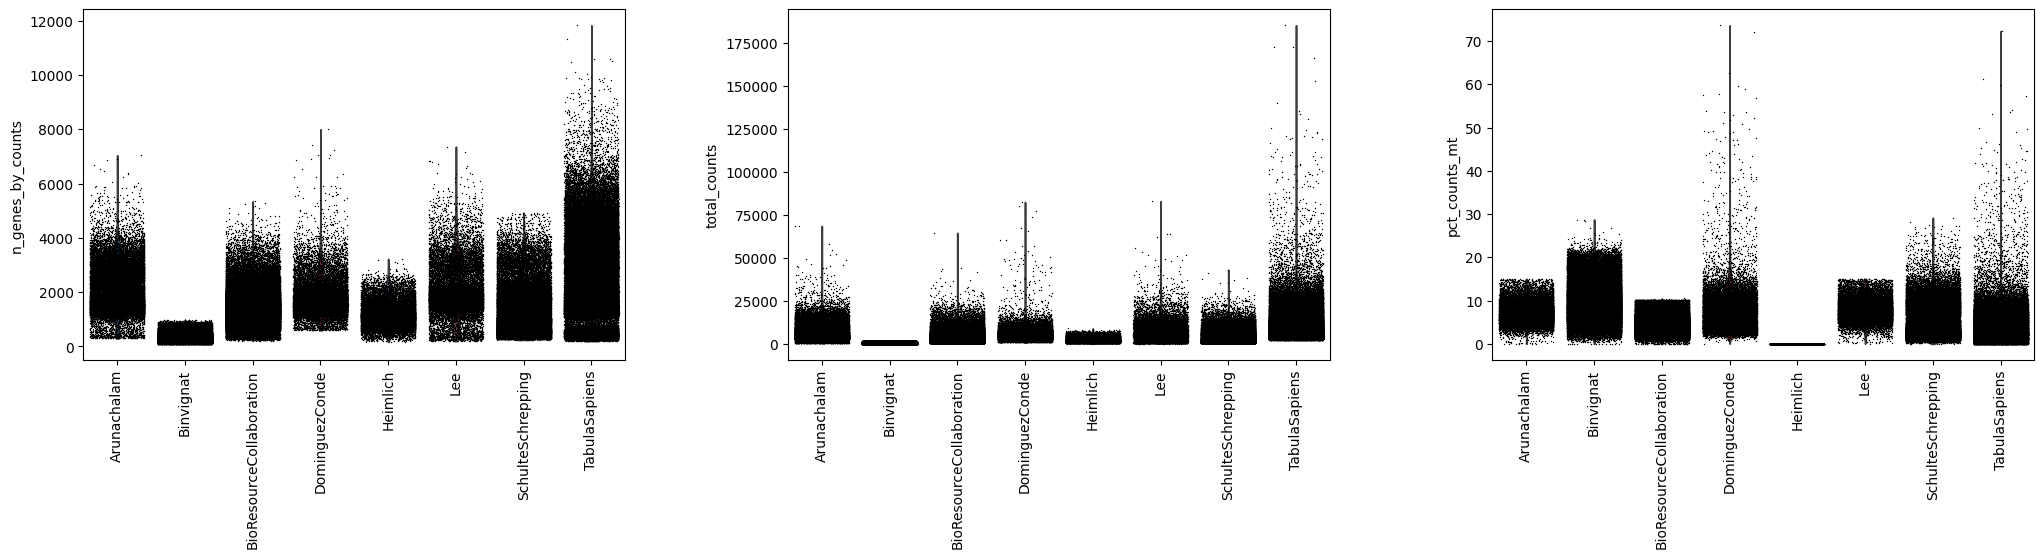

In [27]:
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=True, inplace=True, qc_vars=["mt", "ribo", "hb"])

sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
    groupby="dataset_id_custom", 
    rotation=90
)

### Remove cells based on median absolute deviation (MAD)

- 5 for number of total counts and the number of expressed genes
- 3 for % of mitochondrial genes

In [28]:
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

In [29]:
adata.obs["outlier"] = (
    is_outlier(adata, "log1p_total_counts", 5)
    | is_outlier(adata, "log1p_n_genes_by_counts", 5)
    | is_outlier(adata, "pct_counts_mt", 3)
)
adata.obs.outlier.value_counts()

outlier
False    339246
True      32145
Name: count, dtype: int64

In [30]:
# remove outlier cells
adata_filtered = adata[(~adata.obs.outlier)].copy()
adata_filtered

AnnData object with n_obs × n_vars = 339246 × 47250
    obs: 'soma_joinid', 'dataset_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'donor_id', 'sex', 'assay', 'cell_type', 'collection_doi_label', 'dataset_title', 'citation', 'dataset_id_custom', 'cell_type_broad', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_type', 'feature_length', 'nnz', 'n_measured_obs', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'dataset_id_custom_colors'

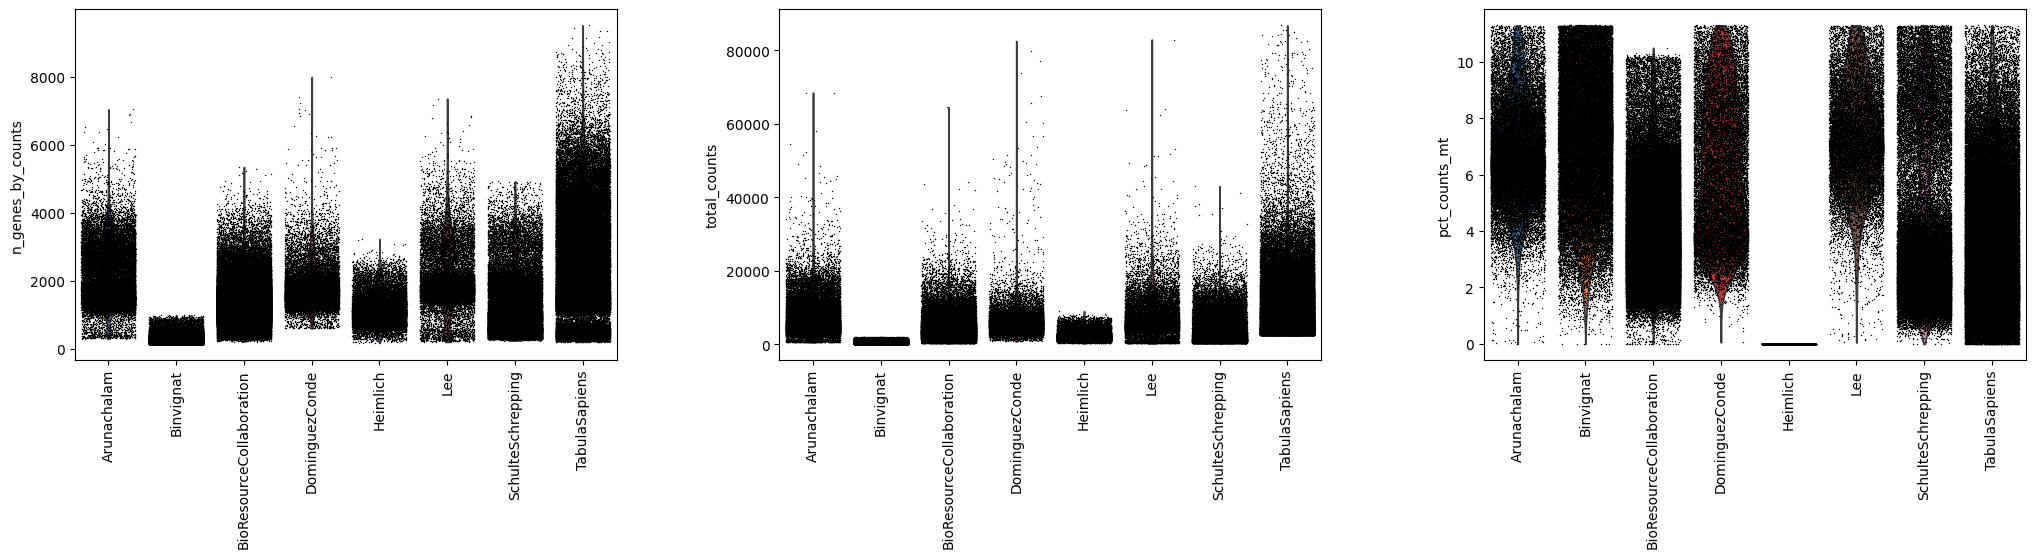

In [31]:
sc.pl.violin(
    adata_filtered,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
    groupby="dataset_id_custom", 
    rotation=90
)

In [33]:
# for integration we need 'batch' and 'sample' columns

# copy the donor_id to new columns 'sample' and 'batch' in obs
adata_filtered.obs["sample"] = adata_filtered.obs["donor_id"]
adata_filtered.obs["batch"] = adata_filtered.obs["donor_id"]

# remove cell types from object that have only 5 or less cells per dataset_id
cell_counts = adata_filtered.obs.groupby(["dataset_id_custom", "cell_type_broad"]).size()
to_remove = cell_counts[cell_counts <= 5]
mask = adata_filtered.obs.set_index(["dataset_id_custom", "cell_type_broad"]).index.isin(to_remove.index)
adata_filtered_rarecells = adata_filtered[~mask].copy()
adata_filtered_rarecells

/tmp/ipykernel_1258837/2325288188.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cell_counts = adata_filtered.obs.groupby(["dataset_id_custom", "cell_type_broad"]).size()


AnnData object with n_obs × n_vars = 339242 × 47250
    obs: 'soma_joinid', 'dataset_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'donor_id', 'sex', 'assay', 'cell_type', 'collection_doi_label', 'dataset_title', 'citation', 'dataset_id_custom', 'cell_type_broad', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'sample', 'batch'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_type', 'feature_length', 'nnz', 'n_measured_obs', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'dataset_id_custom_colors'

# Save data to disc

Each dataset that is left after filtering will be saved individually to be used later for deconvBench. The correct rds files for deconvBench will be created from the h5ad files in a separate R script.

In [34]:
#adata_filtered_rarecells.write_h5ad('/nfs/data/omnideconv_benchmarking_clean/data/singleCellXGeneCensus/merged_healthy_blood_noHao.h5ad')
adata_filtered_rarecells = sc.read_h5ad('/nfs/data/omnideconv_benchmarking_clean/data/singleCellXGeneCensus/merged_healthy_blood_noHao.h5ad')

Prepare files for integration

In [35]:
# add additional cell-type level with even more coarse annotation (to be used for scANVI)
df = pd.read_excel('blood_scANVI_cell_types.xlsx')
df.iloc[:, 1] = df.iloc[:, 1].fillna('NA')
mapping_coarse = dict(zip(df.iloc[:, 0], df.iloc[:, 1]))

adata_filtered_rarecells.obs["cell_type_coarse"] = adata_filtered_rarecells.obs["cell_type"].replace(mapping_coarse)
adata_filtered_rarecells.obs["cell_type_coarse"] = adata_filtered_rarecells.obs["cell_type_coarse"].astype("category").cat.remove_unused_categories()

# set batch ID
adata_filtered_rarecells.obs["batch"] = adata_filtered_rarecells.obs["donor_id"]

/tmp/ipykernel_1258837/1791534271.py:6: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  adata_filtered_rarecells.obs["cell_type_coarse"] = adata_filtered_rarecells.obs["cell_type"].replace(mapping_coarse)


In [72]:
adata_filtered_rarecells.obs["cell_type_coarse"].value_counts()

cell_type_coarse
T_NK_cells       182717
Myeloid_cells     81014
Neutrophils       28894
B_cells           27545
RBC               11371
Platelets          3917
pDCs               2164
NA                 1149
HSC                 385
ILC                  46
Basophils            40
Name: count, dtype: int64

## Create h5ad file for Hao dataset

Use our previously filtered and annotated version of the Hao dataset and create a h5ad file from it to use it for integration.


In [1]:
import anndata as ad
import anndata2ri
import rpy2
import rpy2.robjects as ro
seurat = ro.packages.importr('Seurat')

sce = ro.r(f'as.SingleCellExperiment(readRDS("/nfs/data/omnideconv_benchmarking_clean/data/singleCell/hao-complete/seurat_obj.rds"))')
hao = anndata2ri.rpy2py(sce)
hao


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages



AnnData object with n_obs × n_vars = 153135 × 24049
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cell_type', 'batch', 'barcode', 'subset', 'nCount_SCT', 'nFeature_SCT', 'ident'
    obsm: 'X_pca', 'X_umap'
    layers: 'logcounts'

In [2]:
hao.obs.index = hao.obs.index.astype(str)
hao.var.index = hao.var.index.astype(str)

[<Axes: title={'center': 'H3F3A'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'cell_type'}, xlabel='UMAP1', ylabel='UMAP2'>]

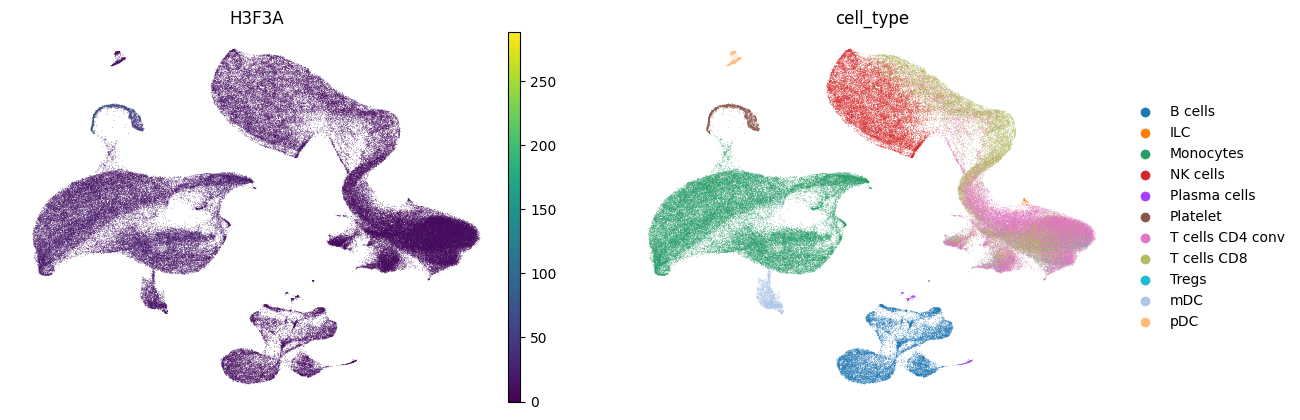

In [35]:
sc.pl.umap(hao, color=['H3F3A','cell_type'], frameon=False, show=False)

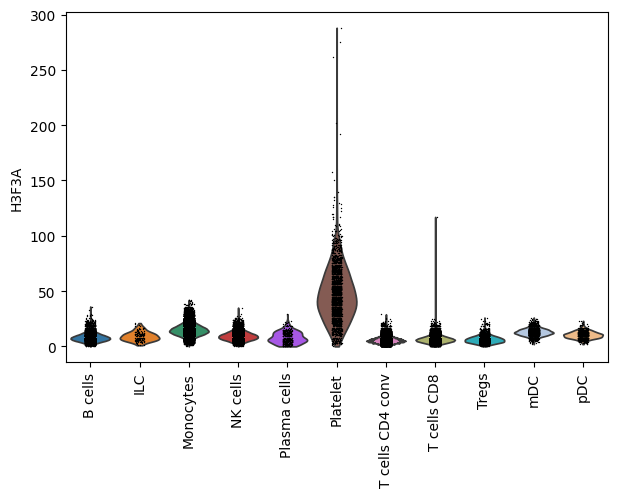

In [38]:
sc.pl.violin(hao, keys='H3F3A', groupby='cell_type', rotation=90)

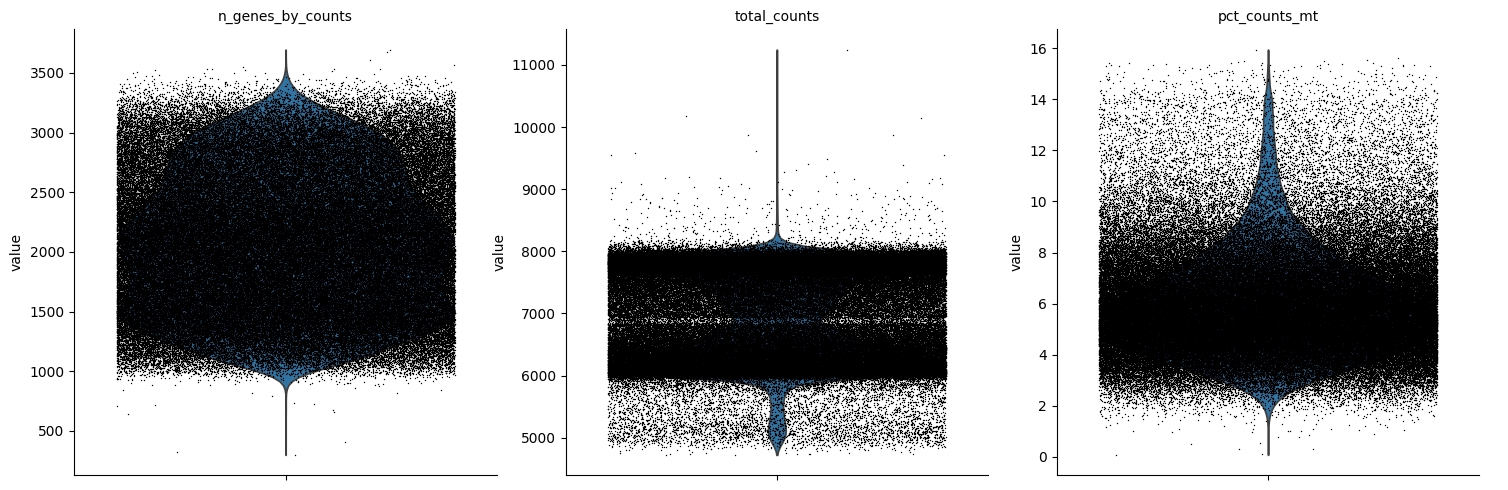

In [5]:
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
hao.var["mt"] = hao.var_names.str.startswith("MT-")
# ribosomal genes
hao.var["ribo"] = hao.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
hao.var["hb"] = hao.var_names.str.contains("^HB[^(P)]")

sc.pp.calculate_qc_metrics(hao, percent_top=None, log1p=True, inplace=True, qc_vars=["mt", "ribo", "hb"])

sc.pl.violin(
    hao,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
    rotation=90
)

In [6]:
# prepare Hao dataset for integration
hao.obs['cell_type_hao'] = hao.obs['cell_type'].copy()

mapping_coarse_hao = {
    "Monocytes": "Myeloid_cells",
    "T cells CD4 conv": "T_NK_cells",
    "T cells CD8": "T_NK_cells",
    "NK cells": "T_NK_cells",
    "B cells": "B_cells",
    "mDC": "Myeloid_cells",
    "Tregs": "T_NK_cells",
    "Platelet": "Platelet",
    "pDC": "pDCs",
    "Plasma cells": "B_cells",
    "ILC": "ILC"
}
hao.obs['cell_type_coarse'] = hao.obs['cell_type'].replace(mapping_coarse_hao).astype(str).astype("category")
hao.obs["sample"] = hao.obs["batch"]
hao.obs["dataset_id_custom"] = "Hao"
hao.obs

/tmp/ipykernel_1995019/4132559889.py:17: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  hao.obs['cell_type_coarse'] = hao.obs['cell_type'].replace(mapping_coarse_hao).astype(str).astype("category")


,orig.ident,nCount_RNA,nFeature_RNA,cell_type,batch,barcode,subset,nCount_SCT,nFeature_SCT,ident,...,total_counts_ribo,log1p_total_counts_ribo,pct_counts_ribo,total_counts_hb,log1p_total_counts_hb,pct_counts_hb,cell_type_hao,cell_type_coarse,sample,dataset_id_custom
L1_AAACCCAAGAAACTCA,L1,10823.0,2915,Monocytes,P2,L1_AAACCCAAGAAACTCA,full dataset,7765.0,2855,L1,...,1408.0,7.250636,18.132646,0.0,0.000000,0.000000,Monocytes,Myeloid_cells,P2,Hao
L1_AAACCCAAGACATACA,L1,5864.0,1617,T cells CD4 conv,P1,L1_AAACCCAAGACATACA,full dataset,6453.0,1617,L1,...,2825.0,7.946618,43.778088,1.0,0.693147,0.015497,T cells CD4 conv,T_NK_cells,P1,Hao
L1_AAACCCACAACTGGTT,L1,5067.0,1381,T cells CD8,P4,L1_AAACCCACAACTGGTT,full dataset,6240.0,1381,L1,...,2789.0,7.933797,44.695513,0.0,0.000000,0.000000,T cells CD8,T_NK_cells,P4,Hao
L1_AAACCCACACGTACTA,L1,4786.0,1890,NK cells,P3,L1_AAACCCACACGTACTA,full dataset,6103.0,1893,L1,...,1401.0,7.245655,22.955923,0.0,0.000000,0.000000,NK cells,T_NK_cells,P3,Hao
L1_AAACCCACAGCATACT,L1,6505.0,1621,T cells CD8,P4,L1_AAACCCACAGCATACT,full dataset,6704.0,1621,L1,...,3128.0,8.048469,46.658711,2.0,1.098612,0.029833,T cells CD8,T_NK_cells,P4,Hao
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E2L8_TTTGTTGGTCGTGATT,E2L8,9346.0,2201,T cells CD8,P5,E2L8_TTTGTTGGTCGTGATT,full dataset,7629.0,2196,E2L8,...,3164.0,8.059908,41.473325,0.0,0.000000,0.000000,T cells CD8,T_NK_cells,P5,Hao
E2L8_TTTGTTGGTGTGCCTG,E2L8,9318.0,2938,Monocytes,P5,E2L8_TTTGTTGGTGTGCCTG,full dataset,7686.0,2936,E2L8,...,928.0,6.834109,12.073901,1.0,0.693147,0.013011,Monocytes,Myeloid_cells,P5,Hao
E2L8_TTTGTTGGTTAGTTCG,E2L8,11619.0,3224,B cells,P8,E2L8_TTTGTTGGTTAGTTCG,full dataset,7963.0,3069,E2L8,...,2323.0,7.751045,29.172422,0.0,0.000000,0.000000,B cells,B_cells,P8,Hao
E2L8_TTTGTTGGTTGGCTAT,E2L8,15436.0,3999,Monocytes,P5,E2L8_TTTGTTGGTTGGCTAT,full dataset,7984.0,3188,E2L8,...,1496.0,7.311218,18.737475,1.0,0.693147,0.012525,Monocytes,Myeloid_cells,P5,Hao


### Fix genes for Hao

In [7]:
from hugo_unifier import unify
unified_symbols, stats = unify(hao.var.index, return_stats=True)

In [8]:
from collections import Counter

hao.var.index = unified_symbols
Counter(hao.var.index)

Counter({'LINC00299': 3,
         'ITFG2-AS1': 3,
         'TTLL10': 2,
         'PLA2G2C': 2,
         'USP48': 2,
         'MYT1': 2,
         'JUN-DT': 2,
         'AK4': 2,
         'NTNG2': 2,
         'CTSK': 2,
         'FCRLB': 2,
         'USP21': 2,
         'RGS5': 2,
         'PRDX6': 2,
         'LAMC1': 2,
         'ATP2B4': 2,
         'SRGAP3': 2,
         'LINC01705': 2,
         'TBCE': 2,
         'RRM2': 2,
         'LINC01819': 2,
         'ZFP36L2': 2,
         'LINC01122': 2,
         'SLC4A4': 2,
         'LINC01291': 2,
         'TCF7L1': 2,
         'SULT1C4': 2,
         'MYO1C': 2,
         'TANK': 2,
         'CPOX': 2,
         'PMP22': 2,
         'LINC01237': 2,
         'LRCH4': 2,
         'GALNT15': 2,
         'CYB561D2': 2,
         'ATXN7': 2,
         'CNKSR3': 2,
         'POLK': 2,
         'MYLK-AS1': 2,
         'MCM7': 2,
         'SIAH2-AS1': 2,
         'PRKCSH': 2,
         'CCDC39': 2,
         'SLC6A4': 2,
         'SLIT3': 2,
         '

In [9]:
hao.var_names_make_unique()
Counter(hao.var.index)

Counter({'AL627309.1': 1,
         'AL627309.3': 1,
         'AL627309.4': 1,
         'AL669831.2': 1,
         'AL669831.5': 1,
         'FAM87B': 1,
         'LINC00115': 1,
         'FAM41C': 1,
         'AL645608.3': 1,
         'AL645608.5': 1,
         'SAMD11': 1,
         'NOC2L': 1,
         'KLHL17': 1,
         'PLEKHN1': 1,
         'PERM1': 1,
         'AL645608.8': 1,
         'HES4': 1,
         'ISG15': 1,
         'AL645608.2': 1,
         'AGRN': 1,
         'AL645608.9': 1,
         'RNF223': 1,
         'C1orf159': 1,
         'LINC01342': 1,
         'AL390719.2': 1,
         'TTLL10-AS1': 1,
         'TTLL10': 1,
         'TNFRSF18': 1,
         'TNFRSF4': 1,
         'SDF4': 1,
         'B3GALT6': 1,
         'C1QTNF12': 1,
         'AL162741.1': 1,
         'UBE2J2': 1,
         'LINC01786': 1,
         'SCNN1D': 1,
         'ACAP3': 1,
         'PUSL1': 1,
         'INTS11': 1,
         'CPTP': 1,
         'TAS1R3': 1,
         'DVL1': 1,
         'MXRA8': 1,


In [11]:
# write hao anndata to disc
hao.write_h5ad('/nfs/data/omnideconv_benchmarking_clean/data/singleCell/hao-complete/anndata.h5ad')

## save each dataset as h5ad

In [90]:
base_path = '/nfs/data/omnideconv_benchmarking_clean/data/singleCellXGeneCensus/'

for dataset_id in adata_filtered_rarecells.obs["dataset_id_custom"].unique():
    # Create a directory for this dataset
    dataset_dir = os.path.join(base_path, dataset_id)
    os.makedirs(dataset_dir, exist_ok=True)

    # Subset the AnnData object
    adata_subset = adata_filtered_rarecells[adata_filtered_rarecells.obs["dataset_id_custom"] == dataset_id]

    # create raw and normalized layers
    adata_subset.layers["counts"] = adata_subset.X
    adata_subset.layers["cpm"] = sc.pp.normalize_total(adata_subset, target_sum=1e6, inplace=False)['X']
    
    # Define filename
    filename = os.path.join(dataset_dir, "anndata.h5ad")
    
    # Save the subset as an .h5ad file
    adata_subset.write_h5ad(filename)

    print(f"Saved {filename}")

/tmp/ipykernel_1258837/1556601132.py:12: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata_subset.layers["counts"] = adata_subset.X
/nfs/home/students/adietrich/.conda/envs/cellxgene_census/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Saved /nfs/data/omnideconv_benchmarking_clean/data/singleCellXGeneCensus/Binvignat/anndata.h5ad


/tmp/ipykernel_1258837/1556601132.py:12: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata_subset.layers["counts"] = adata_subset.X
/nfs/home/students/adietrich/.conda/envs/cellxgene_census/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Saved /nfs/data/omnideconv_benchmarking_clean/data/singleCellXGeneCensus/Lee/anndata.h5ad


/tmp/ipykernel_1258837/1556601132.py:12: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata_subset.layers["counts"] = adata_subset.X
/nfs/home/students/adietrich/.conda/envs/cellxgene_census/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Saved /nfs/data/omnideconv_benchmarking_clean/data/singleCellXGeneCensus/Heimlich/anndata.h5ad


/tmp/ipykernel_1258837/1556601132.py:12: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata_subset.layers["counts"] = adata_subset.X
/nfs/home/students/adietrich/.conda/envs/cellxgene_census/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Saved /nfs/data/omnideconv_benchmarking_clean/data/singleCellXGeneCensus/Arunachalam/anndata.h5ad


/tmp/ipykernel_1258837/1556601132.py:12: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata_subset.layers["counts"] = adata_subset.X
/nfs/home/students/adietrich/.conda/envs/cellxgene_census/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Saved /nfs/data/omnideconv_benchmarking_clean/data/singleCellXGeneCensus/SchulteSchrepping/anndata.h5ad


/tmp/ipykernel_1258837/1556601132.py:12: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata_subset.layers["counts"] = adata_subset.X
/nfs/home/students/adietrich/.conda/envs/cellxgene_census/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Saved /nfs/data/omnideconv_benchmarking_clean/data/singleCellXGeneCensus/DominguezConde/anndata.h5ad


/tmp/ipykernel_1258837/1556601132.py:12: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata_subset.layers["counts"] = adata_subset.X
/nfs/home/students/adietrich/.conda/envs/cellxgene_census/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Saved /nfs/data/omnideconv_benchmarking_clean/data/singleCellXGeneCensus/BioResourceCollaboration/anndata.h5ad


/tmp/ipykernel_1258837/1556601132.py:12: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata_subset.layers["counts"] = adata_subset.X
/nfs/home/students/adietrich/.conda/envs/cellxgene_census/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Saved /nfs/data/omnideconv_benchmarking_clean/data/singleCellXGeneCensus/TabulaSapiens/anndata.h5ad


# DimRed

In [69]:
adata_filtered.layers["counts"] = adata_filtered.X
sc.pp.normalize_total(adata_filtered, target_sum=1e6)
sc.pp.log1p(adata_filtered)
sc.pp.highly_variable_genes(adata_filtered, n_top_genes=500, flavor="seurat_v3", layer="counts")
adata_filtered

/nfs/home/students/adietrich/.conda/envs/cellxgene_census/lib/python3.12/site-packages/scanpy/preprocessing/_highly_variable_genes.py:74: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


AnnData object with n_obs × n_vars = 474475 × 47250
    obs: 'soma_joinid', 'dataset_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'donor_id', 'sex', 'assay', 'cell_type', 'collection_doi_label', 'dataset_title', 'citation', 'dataset_id_custom', 'cell_type_broad', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_type', 'feature_length', 'nnz', 'n_measured_obs', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'dataset_id_custom_colors', 'log1p', 'hvg'
    layers: 'counts'

In [70]:
sc.tl.pca(adata_filtered, svd_solver="arpack", mask_var="highly_variable")

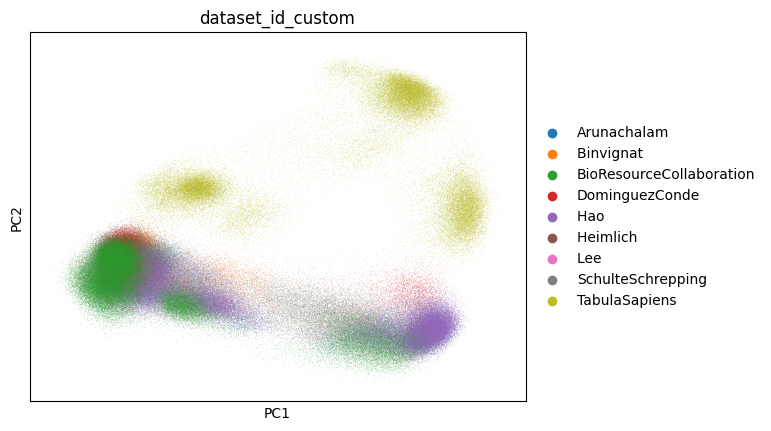

In [77]:
sc.pl.pca(adata_filtered, color="dataset_id_custom")

In [72]:
sc.pp.neighbors(adata_filtered)
sc.tl.umap(adata_filtered)

/nfs/home/students/adietrich/.conda/envs/cellxgene_census/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


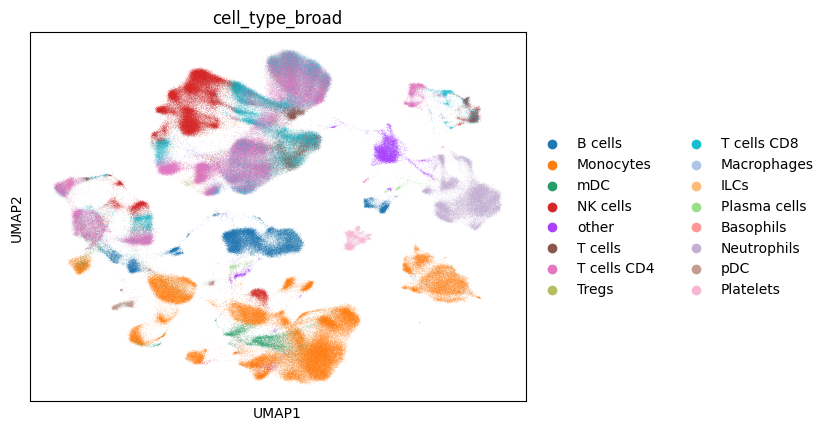

In [83]:
sc.pl.umap(adata_filtered, color="cell_type_broad")

In [115]:
census.close()